In [1]:
import os

In [2]:
import cv2

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pandas as pd

In [5]:
import numpy as np 

In [6]:
import seaborn as sns

In [7]:
import tensorflow as tf

In [8]:
from tensorflow.keras.applications import NASNetMobile, ResNet152V2, DenseNet201,InceptionResNetV2

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
from tensorflow.keras.models import Sequential, load_model

In [11]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [13]:
from tensorflow.keras.optimizers import Adamax

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

In [15]:
import urllib.request

In [16]:
train_dir = "Dataset"

In [17]:
classes = os.listdir(train_dir)

In [18]:
print("Classes:", classes)

Classes: ['Boot', 'Sandal', 'Shoe']


In [19]:
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(train_dir, cls)))} images")

Boot: 5000 images
Sandal: 5000 images
Shoe: 5000 images


In [20]:
img_size = (100, 100)
batch_size = 64
num_classes = len(classes)

In [21]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode = 'nearest',
    validation_split = 0.2
)

In [22]:
test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [23]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training'
)

Found 12000 images belonging to 3 classes.


In [24]:
test_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle=False
)

Found 3000 images belonging to 3 classes.


In [25]:
x_batch , y_batch = next(train_generator)

In [26]:
len(x_batch)

64

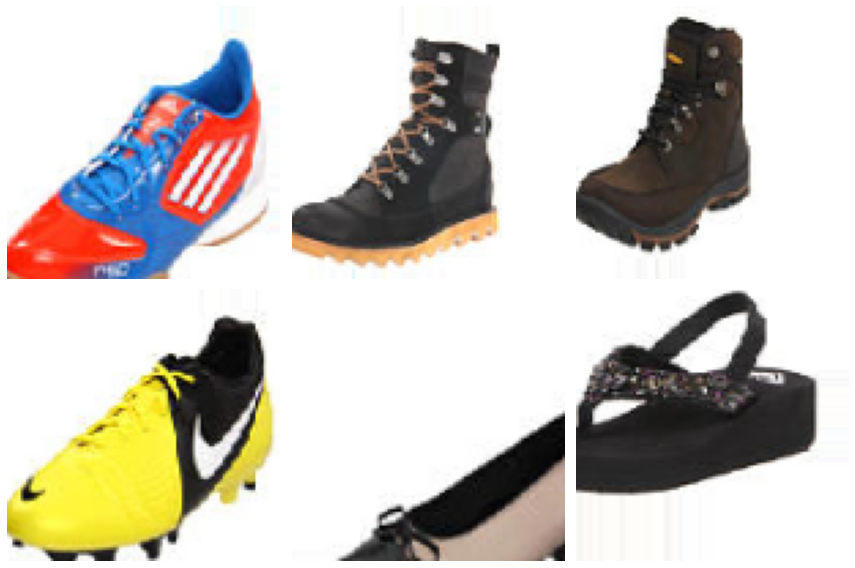

In [27]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [28]:
callbacks = [
   
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=np.sqrt(0.1),
        patience=5,
        #min_lr=1e-6
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True
    )
]

In [29]:
def create_resnetet152V2_model():
    resnetet152V2_base_model = ResNet152V2(include_top= False , weights= 'imagenet' , input_shape= (100,100,3) , pooling= 'max')
    resnetet152V2_model = Sequential([
        resnetet152V2_base_model,
        BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
        Dense(256 , activation= 'relu'),
        Dense(256 , activation= 'relu'),
        Dense(3 , activation= 'softmax')
    ])
    resnetet152V2_model.compile(Adamax(learning_rate= 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return resnetet152V2_model

In [30]:
resnetet152V2_model = create_resnetet152V2_model()

In [31]:
can_train = False

In [32]:
if can_train:
    resnetet152V2_history = resnetet152V2_model.fit(
    train_generator ,
    epochs = 10,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks = callbacks
    )
    resnetet152V2_model.save("Footwear-CLS3-DS-ResNet152V2-Model.keras")
    resnetet152V2_df = pd.DataFrame(resnetet152V2_history.history)
    resnetet152V2_df.to_csv("Footwear-CLS3-DS-ResNet152V2-History.csv", index=False)
else:
    resnetet152V2_model = load_model("Footwear-CLS3-DS-ResNet152V2-Model.keras")
    resnetet152V2_df = pd.read_csv("Footwear-CLS3-DS-ResNet152V2-History.csv")

In [33]:
resnetet152V2_df

,loss,accuracy,val_loss,val_accuracy,lr
0,0.213553,0.919236,0.211151,0.945652,0.001
1,0.090414,0.968666,0.082384,0.973505,0.001
2,0.067112,0.978301,0.098873,0.966712,0.001
3,0.049152,0.983830,0.052651,0.981318,0.001
4,0.044858,0.985590,0.049248,0.984715,0.001
5,0.039709,0.987014,0.133978,0.959918,0.001
6,0.041752,0.986344,0.517941,0.879076,0.001
7,0.036669,0.987265,0.060844,0.980639,0.001
8,0.035629,0.988019,0.074875,0.974185,0.001
9,0.027749,0.990114,0.171550,0.949728,0.001


In [34]:
def display_metrics_plot(train_accuracy, val_accuracy, train_loss, val_loss, learning_rate):
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

    ax[0].set_title('Training Accuracy vs. Epochs')
    ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
    ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='best')

    ax[1].set_title('Training/Validation Loss vs. Epochs')
    ax[1].plot(train_loss, 'o-', label='Train Loss')
    ax[1].plot(val_loss, 'o-', label='Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='best')

    ax[2].set_title('Learning Rate vs. Epochs')
    ax[2].plot(learning_rate, 'o-', label='Learning Rate')
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('Loss')
    ax[2].legend(loc='best')

    plt.tight_layout()
    plt.show()

In [35]:
train_accuracy = resnetet152V2_df['accuracy'].values
val_accuracy = resnetet152V2_df['val_accuracy'].values

train_loss = resnetet152V2_df['loss'].values
val_loss = resnetet152V2_df['val_loss'].values

learning_rate = resnetet152V2_df['lr'].values

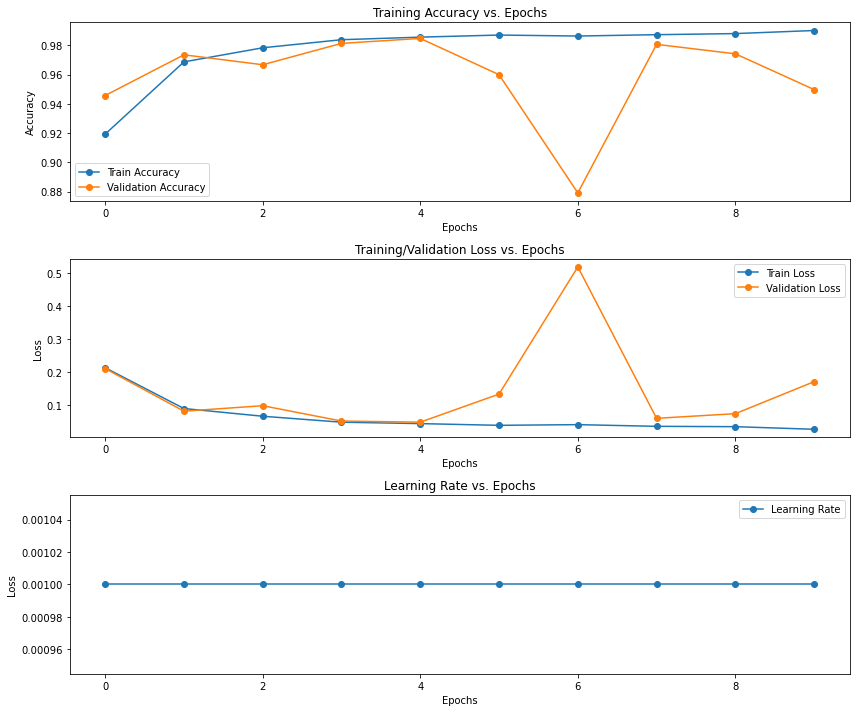

In [36]:
display_metrics_plot(train_accuracy, val_accuracy, train_loss, val_loss, learning_rate)

In [37]:
labels = {value: key for key, value in train_generator.class_indices.items()}

In [38]:
labels

{0: 'Boot', 1: 'Sandal', 2: 'Shoe'}

In [39]:
def model_predictions(model):
    print("\nEvaluating model...")
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes


    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels.values(), yticklabels=labels.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(true_classes,predicted_classes, target_names=labels.values()))
    
    report = classification_report(true_classes, predicted_classes, target_names=labels.values(), output_dict=True)

    accuracy = report['accuracy'] 
    weighted_precision = report['weighted avg']['precision']
    weighted_recall = report['weighted avg']['recall']
    weighted_f1 = report['weighted avg']['f1-score']

    print(f"Accuracy: {accuracy}")
    print(f"Weighted Precision: {weighted_precision}")
    print(f"Weighted Recall: {weighted_recall}")
    print(f"Weighted F1-Score: {weighted_f1}")


Evaluating model...
47/47 [==============================] - 103s 2s/step - loss: 0.1604 - accuracy: 0.9510
Test Loss: 0.1604
Test Accuracy: 0.9510
47/47 [==============================] - 113s 2s/step


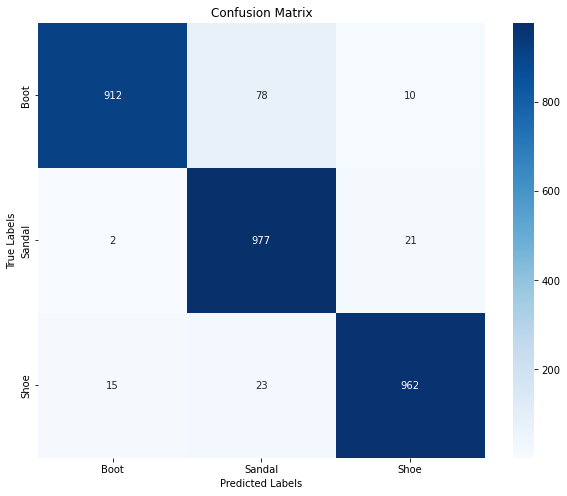


Classification Report:
              precision    recall  f1-score   support

        Boot       0.98      0.91      0.95      1000
      Sandal       0.91      0.98      0.94      1000
        Shoe       0.97      0.96      0.97      1000

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000

Accuracy: 0.9503333333333334
Weighted Precision: 0.9522634005089929
Weighted Recall: 0.9503333333333334
Weighted F1-Score: 0.9504245717507243


In [40]:
model_predictions(resnetet152V2_model)

In [41]:
def create_densenet201_model():
    densenet201_base_model = DenseNet201(include_top= False , weights= 'imagenet' , input_shape= (100,100,3) , pooling= 'max')
    densenet201_model = Sequential([
        densenet201_base_model,
        BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
        Dense(256 , activation= 'relu'),
        Dense(256 , activation= 'relu'),
        Dense(3 , activation= 'softmax')
    ])
    densenet201_model.compile(Adamax(learning_rate= 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return densenet201_model

In [42]:
densenet201_model = create_densenet201_model()

In [43]:
if can_train:
    densenet201_history = densenet201_model.fit(
    train_generator ,
    epochs = 10,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks = callbacks
    )
    densenet201_model.save("Footwear-CLS3-DS-DenseNet201-Model.keras")
    densenet201_df = pd.DataFrame(densenet201_history.history)
    densenet201_df.to_csv("Footwear-CLS3-DS-DenseNet201-History.csv", index=False)
else:
    densenet201_model = load_model("Footwear-CLS3-DS-DenseNet201-Model.keras")
    densenet201_df = pd.read_csv("Footwear-CLS3-DS-DenseNet201-History.csv")

In [44]:
train_accuracy = densenet201_df['accuracy'].values
val_accuracy = densenet201_df['val_accuracy'].values

train_loss = densenet201_df['loss'].values
val_loss = densenet201_df['val_loss'].values

learning_rate = densenet201_df['lr'].values

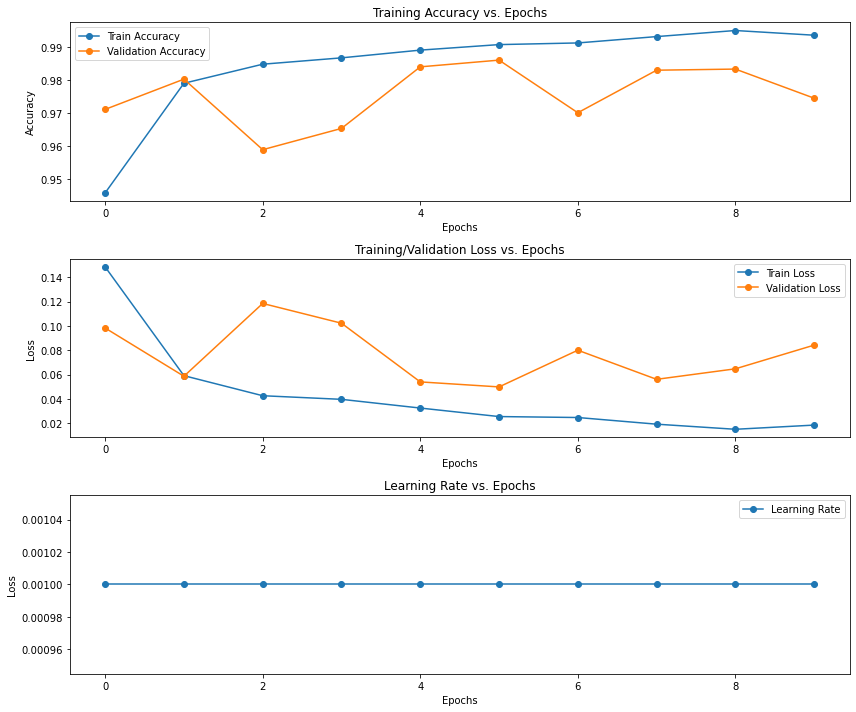

In [45]:
display_metrics_plot(train_accuracy, val_accuracy, train_loss, val_loss, learning_rate)


Evaluating model...
47/47 [==============================] - 68s 1s/step - loss: 0.0858 - accuracy: 0.9750
Test Loss: 0.0858
Test Accuracy: 0.9750
47/47 [==============================] - 70s 1s/step


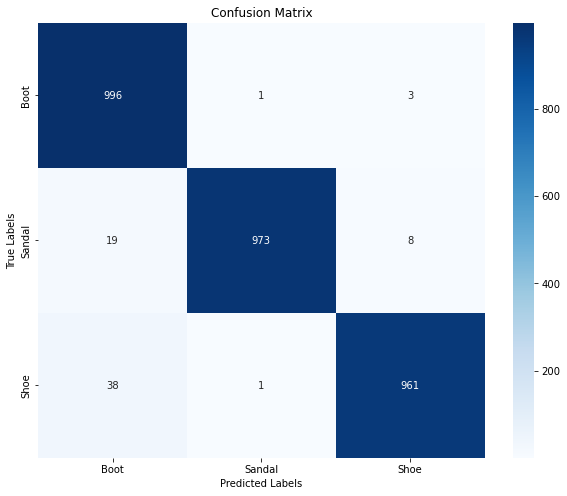


Classification Report:
              precision    recall  f1-score   support

        Boot       0.95      1.00      0.97      1000
      Sandal       1.00      0.97      0.99      1000
        Shoe       0.99      0.96      0.97      1000

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000

Accuracy: 0.9766666666666667
Weighted Precision: 0.9775002637965601
Weighted Recall: 0.9766666666666667
Weighted F1-Score: 0.9767496234792672


In [46]:
model_predictions(densenet201_model)

In [47]:
def create_nasnetmobile_model():
    nasnetmobile_base_model = NASNetMobile(include_top= False , weights= 'imagenet' , input_shape= (100,100,3) , pooling= 'max')
    nasnetmobile_model = Sequential([
        nasnetmobile_base_model,
        BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
        Dense(256 , activation= 'relu'),
        Dense(256 , activation= 'relu'),
        Dense(3 , activation= 'softmax')
    ])
    nasnetmobile_model.compile(Adamax(learning_rate= 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return nasnetmobile_model

In [48]:
nasnetmobile_model = create_nasnetmobile_model()

In [49]:
if can_train:
    nasnetmobile_history = nasnetmobile_model.fit(
    train_generator ,
    epochs = 10,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks = callbacks
    )
    nasnetmobile_model.save("Footwear-CLS3-DS-NASNetMobile-Model.keras")
    nasnetmobile_df = pd.DataFrame(nasnetmobile_history.history)
    nasnetmobile_df.to_csv("Footwear-CLS3-DS-NASNetMobile-History.csv", index=False)
else:
    nasnetmobile_model = load_model("Footwear-CLS3-DS-NASNetMobile-Model.keras")
    nasnetmobile_df = pd.read_csv("Footwear-CLS3-DS-NASNetMobile-History.csv")

In [50]:
train_accuracy = nasnetmobile_df['accuracy'].values
val_accuracy = nasnetmobile_df['val_accuracy'].values

train_loss = nasnetmobile_df['loss'].values
val_loss = nasnetmobile_df['val_loss'].values

learning_rate = nasnetmobile_df['lr'].values

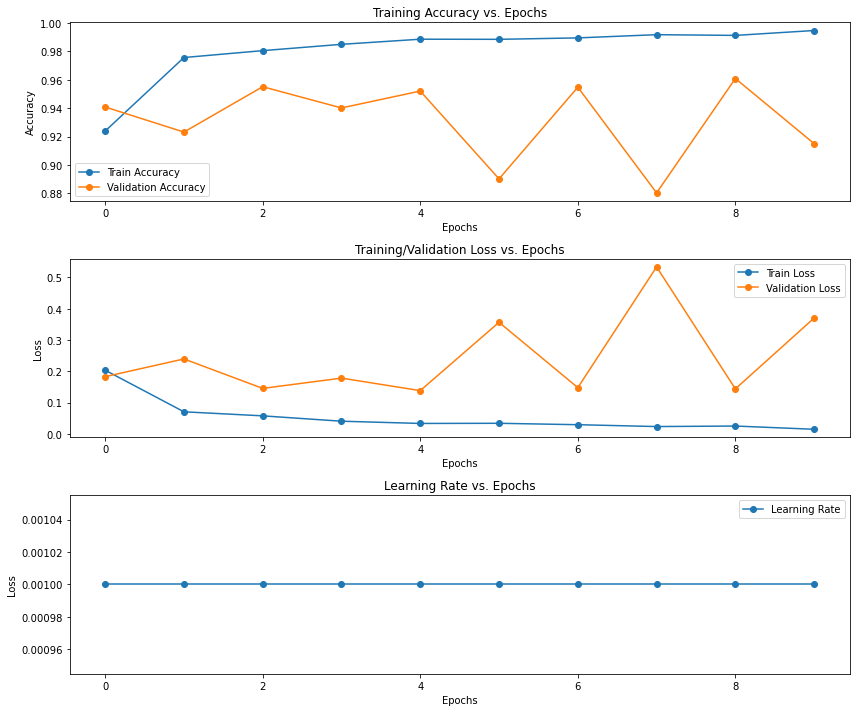

In [51]:
display_metrics_plot(train_accuracy, val_accuracy, train_loss, val_loss, learning_rate)


Evaluating model...
47/47 [==============================] - 27s 504ms/step - loss: 0.3696 - accuracy: 0.9227
Test Loss: 0.3696
Test Accuracy: 0.9227
47/47 [==============================] - 27s 502ms/step


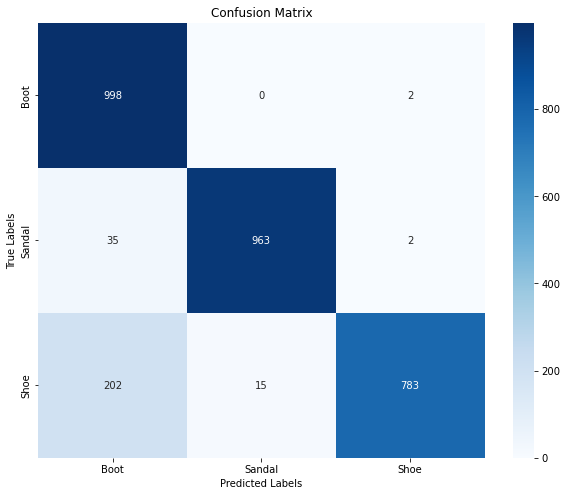


Classification Report:
              precision    recall  f1-score   support

        Boot       0.81      1.00      0.89      1000
      Sandal       0.98      0.96      0.97      1000
        Shoe       0.99      0.78      0.88      1000

    accuracy                           0.91      3000
   macro avg       0.93      0.91      0.91      3000
weighted avg       0.93      0.91      0.91      3000

Accuracy: 0.9146666666666666
Weighted Precision: 0.9292257168523458
Weighted Recall: 0.9146666666666666
Weighted F1-Score: 0.9143682463518569


In [52]:
model_predictions(nasnetmobile_model)

In [53]:
def create_inceptionresnetv2_model():
    inceptionresnetv2_base_model = InceptionResNetV2(include_top= False , weights= 'imagenet' , input_shape= (100,100,3) , pooling= 'max')
    inceptionresnetv2_model = Sequential([
        inceptionresnetv2_base_model,
        BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
        Dense(256 , activation= 'relu'),
        Dense(256 , activation= 'relu'),
        Dense(3 , activation= 'softmax')
    ])
    inceptionresnetv2_model.compile(Adamax(learning_rate= 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return inceptionresnetv2_model

In [54]:
inceptionresnetv2_model = create_inceptionresnetv2_model()

In [55]:
if can_train:
    inceptionresnetv2_history = inceptionresnetv2_model.fit(
    train_generator ,
    epochs = 10,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks = callbacks
    )
    inceptionresnetv2_model.save("Footwear-CLS3-DS-InceptionResNetV2-Model.keras")
    inceptionresnetv2_df = pd.DataFrame(inceptionresnetv2_history.history)
    inceptionresnetv2_df.to_csv("Footwear-CLS3-DS-InceptionResNetV2-History.csv", index=False)
else:
    inceptionresnetv2_model = load_model("Footwear-CLS3-DS-InceptionResNetV2-Model.keras")
    inceptionresnetv2_df = pd.read_csv("Footwear-CLS3-DS-InceptionResNetV2-History.csv")

In [56]:
train_accuracy = inceptionresnetv2_df['accuracy'].values
val_accuracy = inceptionresnetv2_df['val_accuracy'].values

train_loss = inceptionresnetv2_df['loss'].values
val_loss = inceptionresnetv2_df['val_loss'].values

learning_rate = inceptionresnetv2_df['lr'].values

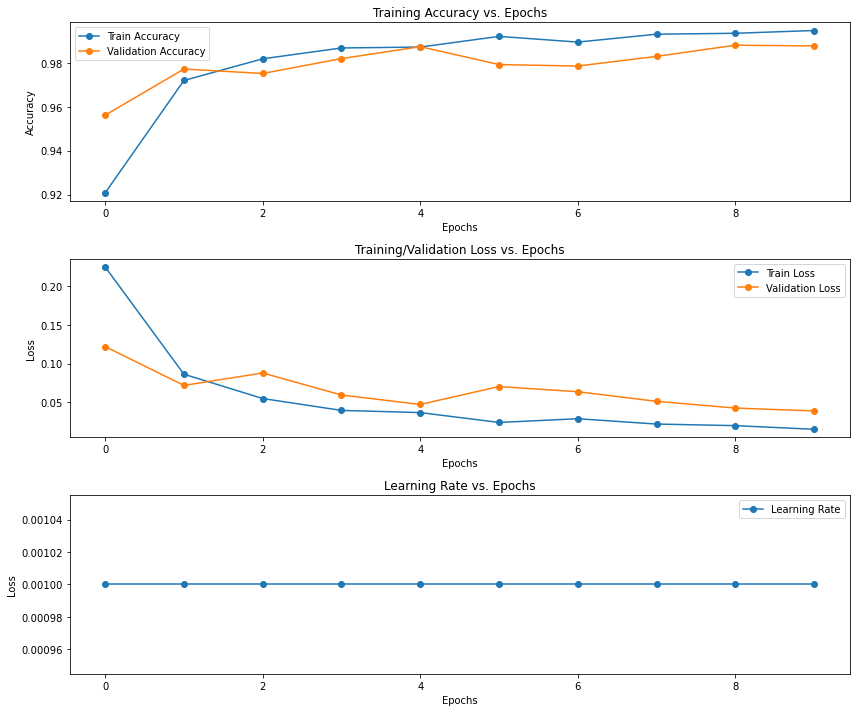

In [57]:
display_metrics_plot(train_accuracy, val_accuracy, train_loss, val_loss, learning_rate)


Evaluating model...
47/47 [==============================] - 49s 986ms/step - loss: 0.0533 - accuracy: 0.9877
Test Loss: 0.0533
Test Accuracy: 0.9877
47/47 [==============================] - 52s 1s/step


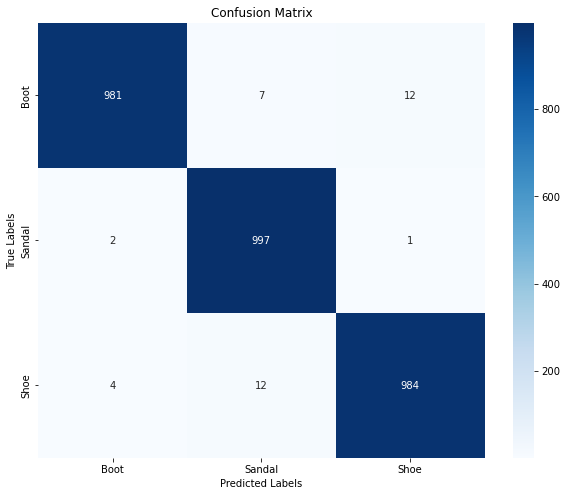


Classification Report:
              precision    recall  f1-score   support

        Boot       0.99      0.98      0.99      1000
      Sandal       0.98      1.00      0.99      1000
        Shoe       0.99      0.98      0.99      1000

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Accuracy: 0.9873333333333333
Weighted Precision: 0.9873936892969153
Weighted Recall: 0.9873333333333333
Weighted F1-Score: 0.9873279124443396


In [58]:
model_predictions(inceptionresnetv2_model)

In [59]:
url = "https://m.media-amazon.com/images/I/81XtHSWQvwL._AC_UY1000_.jpg"
url = "https://m.media-amazon.com/images/I/61f5iLBhpML._AC_UY1000_.jpg"
url = "https://m.media-amazon.com/images/I/41SkDWdpGgL._AC_UY1000_.jpg"
url="https://m.media-amazon.com/images/I/71D+XnRz0tL._AC_UY1000_.jpg"
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

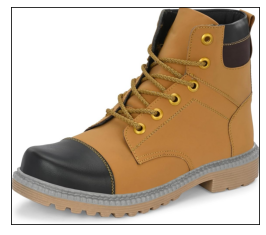

In [60]:
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

In [61]:
image_size = 100

In [62]:
image = cv2.resize(image, (image_size,image_size))
#image = (image-mean)/(std+1e-7)
image = image/255
image = image.reshape((1, image_size, image_size, 3))

In [63]:
prediction = inceptionresnetv2_model.predict(image)

1/1 [==============================] - 2s 2s/step


In [64]:
predicted_class = prediction.argmax()

In [65]:
print('Predicted class: ', classes[predicted_class])

Predicted class:  Boot
